# Machine Learning Advanced Nanodegree

## Capstone Project

<hr>

### <u>Table of contents</u>

* <a href="#Domain-Background">Domain Background</a>
* <a href="#Problem-Statement">Problem Statement</a> 
* <a href="#Data-Overview-and-Exploratory-Analysis">Data Overview and Exploratory Analysis</a>
* <a href="#Data-Cleaning">Data Cleaning</a>
* <a href="#Vectorization">Vectorization</a>
* <a href="#Baseline-Model">Baseline Model</a>
* <a href="#Model-Application">Model Application</a>

### <u>Domain Background</u>

My project draws upon the domain of document classification with an emphasis on the natural language processing component of document classification. Machine learning has been successfully used to classify documents by topic for several decades. However, machine learning techniques do not perform as well when performing sentiment analysis which requires the parsing of more complex language structures. This is where ideas from natural language processing must be applied. My aim with this project is to make progress towards solving a complex natural language processing problem using machine learning. I think that it would be very beneficial if computers could interpret and produce the same kind of natural language of which even young children are capable. This would allow machine learning to be applied to a wider variety of tasks than it is currently capable of solving. In particular, machine learning could be applied to many problems that are not well structured and for which there is not much training data.
This capstone project is based on the Toxic Comment Classification Challenge

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).
With more people joining social media than ever before, it becomes imperative that this problem is solved. Classifying toxic comments (obscene, threat, insult, identity‒based hate) will be the core of this project.

### <u>Problem Statement</u>

In this project, I will build a multi‒headed model that will be capable of detecting different types of toxicity like threats, obscenity, insults, and identity‒based hate from a given comment. I’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current models will hopefully help online discussion become more productive and respectful.

This is a supervised multi‒class classification problem and as such different measurable evaluation metrics could be applied. Given a comment, the solution will be a machine learning model that receives as input the comment and outputs either a class prediction or a class probabilty for every toxicity type.

### <u>Data Overview and Exploratory Analysis</u>

I’ll be using a dataset of comments from Wikipedia’s talk page edits which have been labeled by human raters for toxic behavior.
The types of toxicity are:

* toxic 
* severe toxic
* obscene
* threat
* insult 
* identity̲hate

#### Importing Data

In [1]:
local = 1

import numpy as np
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Styling

plt.style.use('ggplot')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

if local:
    train = pd.read_csv("./data/train.csv")
    holdout = pd.read_csv("./data/test.csv")
else :
    train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
    holdout = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")


# Lets have a peek at our training data

display(HTML(train.head(n = 5).to_html()))

unseenRandomTextsArray = ["Which music is this?",
                     "This guy is spot on with his indian accent. Hats off.",
                     "Canadians are so nice.",
                     "Lmfao seemed so hard to hold it together, amazing!",
                     "I know this was hilarious and all but did anyone else feel bad for him when he said he had to take time off work unpaid and he had to cycle to work at 4 in the morning?",
                     "Fuck you motherfucker",
                     "shut up you faggot. go back to your shit country",
                     "why are all people here gay?"]
unseenRandomTexts = pd.Series(unseenRandomTextsArray)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


None

In [3]:
# Lets have a peek at our holdout data

display(HTML(holdout.sample(n = 5).to_html()))

,id,comment_text
97739,a31630ee3c5dc34d,"::While yer looking for one of those, do we re..."
111405,b9dc4274545f3aa4,"←I've created a brief article, but it needs mu..."
9088,0f2e0a0985be718f,:An anonymous idiot.
45786,4bf82b79face72a0,== Not true == \n\n Blacks deserve to be kille...
82048,88e8d82c12a804b7,does this warrant inclusion?


In [4]:
display(holdout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


None

#### Data Set Overview

Our train and holdout data consists of 159571 and 153164 observations respectively. Both the train and holdout data do not have any null values. 😅 . We do see some \n in both the train and test data though. We'll clean them in the text cleaning phase

In [5]:
# Lets create a separate dataframe to perform EDA on

def findClean(series):
    s = sum(series)
    if s == 0:
        return 1
    else:
        return 0
    
eda = train.copy()
eda["clean"] = eda.iloc[:, 2:].apply(findClean, axis = 1)

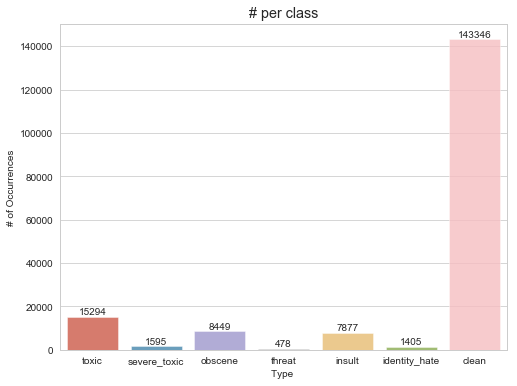

In [6]:
# Lets study class imbalance

x = eda.iloc[:, 2:].sum()
#plot
plt.figure(figsize = (8, 6))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize = 10)
plt.xlabel('Type ', fontsize = 10)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom')

plt.savefig('./images/ToxicityOccurences.png')

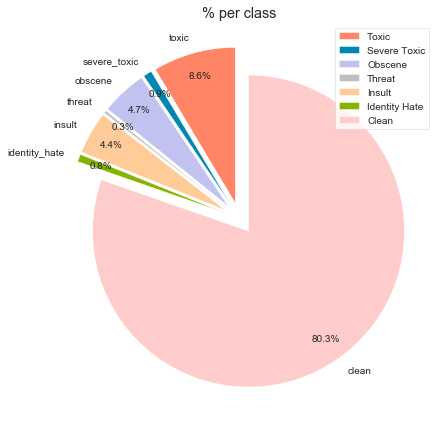

In [7]:
x.plot(kind = 'pie', 
       explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
       figsize = (8, 6), autopct = '%1.1f%%',
       shadow = False, pctdistance = 0.85, startangle = 90,
       colors = ['#ff8566','#0086b3','#c2c2f0','#bfbfbf', '#ffcc99', '#86b300', '#ffcccc'])
plt.title("% per class")
plt.ylabel("")
plt.tight_layout()
plt.legend(["Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate", "Clean"])

plt.savefig('./images/ToxicityOccurencesPie.png')

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems

In [8]:
# Lets create a wordcloud to see some common words in each type of toxicity category.

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def createWordCloud(commentSeries, color, name):
    wc = WordCloud(collocations = False, width = 400, height = 300, max_words = 2000, stopwords = stopwords).generate(" ".join(commentSeries))
    plt.figure( figsize=(8, 6), facecolor = 'k')
    plt.imshow(wc.recolor(colormap = color , random_state = 17), alpha=0.98)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    name = "./images/" + name
    plt.savefig(name)

##### Words frequented in Clean Comments

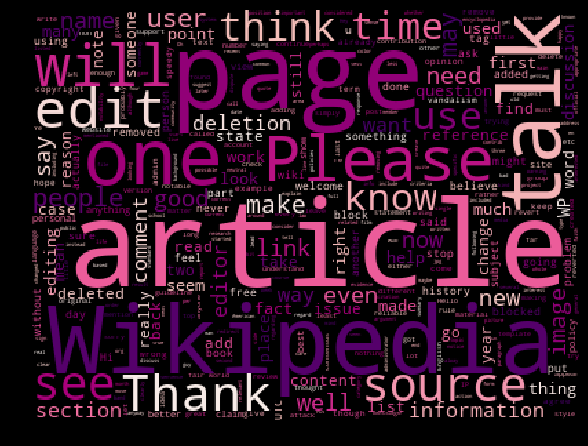

In [9]:
clean_comments = eda[eda["clean"] == 1]["comment_text"]
createWordCloud(clean_comments, "RdPu", "cleanWC.png")

##### Words frequented in Toxic Comments

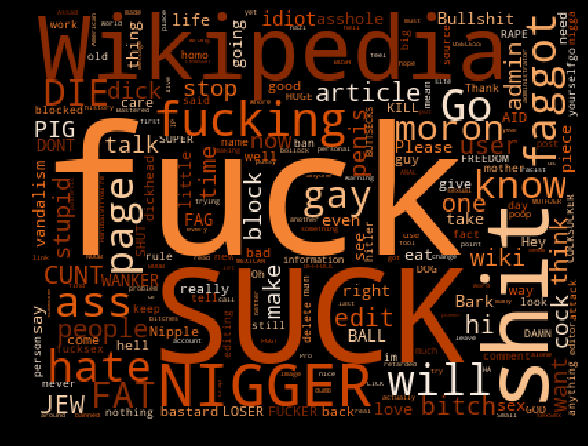

In [10]:
toxic_comments = eda[eda["toxic"] == 1]["comment_text"]
createWordCloud(toxic_comments, "Oranges", "toxicWC.png")

##### Words frequented in Severe Toxic Comments

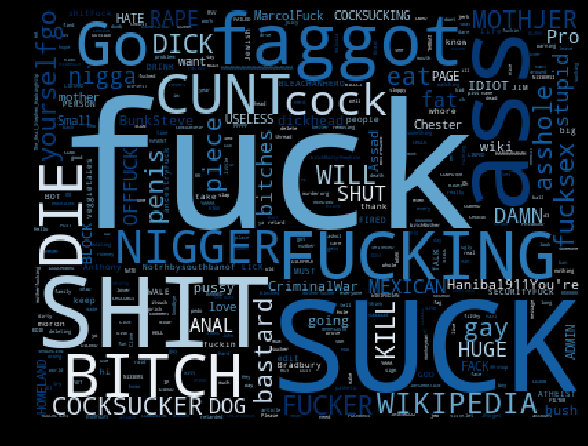

In [11]:
severe_toxic_comments = eda[eda["severe_toxic"] == 1]["comment_text"]
createWordCloud(severe_toxic_comments, "Blues", "stoxicWC.png")

##### Words frequented in Obscence Comments

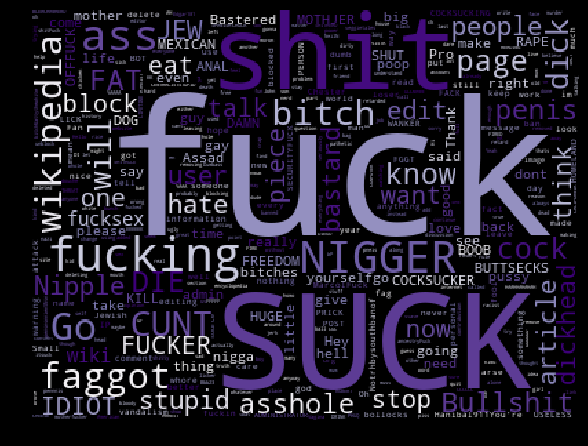

In [12]:
obscene_comments = eda[eda["obscene"] == 1]["comment_text"]
createWordCloud(obscene_comments, "Purples",  "obsceneWC.png")

##### Words frequented in Threat Comments

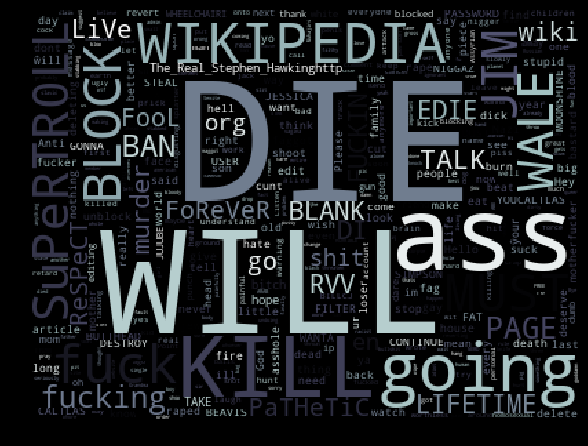

In [13]:
threat_comments = eda[eda["threat"] == 1]["comment_text"]
createWordCloud(threat_comments, "bone", "threatWC.png")

##### Words frequented in Insult Comments

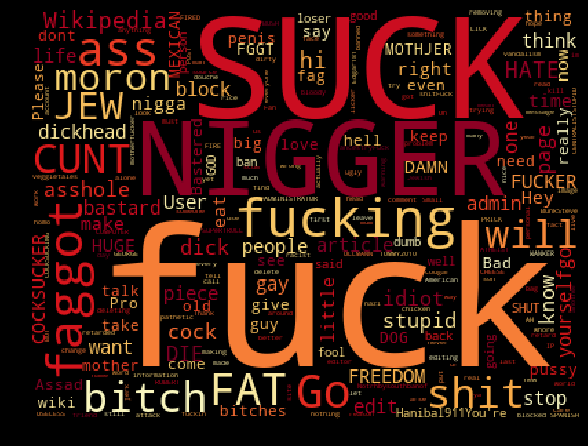

In [14]:
insult_comments = eda[eda["insult"] == 1]["comment_text"]
createWordCloud(insult_comments, "YlOrRd", "insultWC.png")

##### Words frequented in Identity Hate Comments

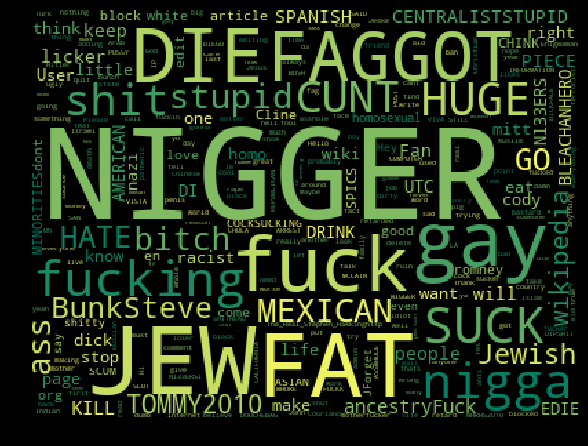

In [15]:
ihate_comments = eda[eda["identity_hate"] == 1]["comment_text"]
createWordCloud(ihate_comments, "summer", "idWC.png")

### Data Cleaning

For our machine learning models to work, we will need to convert our raw data (comment_text) into a format that is consumable by them. We do this by vectorization. Some of the common vectorized representation are `Bag of Words` and `Tfidf`. Both of these representations are very sparse matrix. In order to reduce the sparsity, we will need to trim down our vocabulary. We do this by removing words that are not relevant and converting different words that convey the same meaning into a single word.

> Lets clean out text by `removing stopwords` and `stemming` our comments.
  `Stopwords` : Common words such as 'the', 'we' etc that won't help us in our semantic analysis.
  `Stemming` : Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or     root form. Eg love, loved and loving mean the same thing and performing a stem operation on them will reduce all of   them into the same root form 'lov'. This will further reduce our vocab and reduce the matrix sparsity of our bag of   words/ ngrams representations


In [16]:
# Text Preprocessing
import re
import nltk
# nltk.download("all")

# Stopwords
from nltk.corpus import stopwords

import string
from nltk.tokenize import word_tokenize

# Stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

# remove '\\n'
train['comment_text'] = train['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
holdout['comment_text'] = holdout['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
# remove any text starting with User... 
train['comment_text'] = train['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
holdout['comment_text'] = holdout['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))

# Lets see if the \n is removed
display(train.head(5))

def cleanComment(comment):
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word.lower()) for word in word_tokenize(comment) if word.lower() not in stopwords.words("english")]
    return " ".join(words)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
# Example of cleaning a text.
# Notice how all stopwords are removed and words with the same meaning (loves, love, lovely) 
# are reduced to the same base word love

originalText = "This is Mr Rob. Mr Rob loves ice creams. Rob is also in love with football. Football is a lovely game"
print(cleanComment(originalText))

mr rob mr rob love ice cream rob also love footbal footbal love game


In [18]:
# Lets Clean our train and holdout data.
# Since cleaning both the train and holdout data took a lot of time,
# I have pickled both the cleaned dataframes for faster development cycles. 
# Change pickle = 0 for cleaning the data again

pickle = 1

if pickle :
    train = pd.read_pickle("./train.pkl")
    holdout = pd.read_pickle("./test.pkl")    
else :
    train["comment_text"] = train["comment_text"].apply(cleanComment)
    holdout["comment_text"] = holdout["comment_text"].apply(cleanComment)
        

display(HTML(train.sample(n = 5).to_html()))
display(HTML(holdout.sample(n = 5).to_html()))

unseenRandomTexts = unseenRandomTexts.apply(cleanComment)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
7151,130e28b799977c5d,ban kontoreg eh mere matter time honest,0,0,0,0,0,0
141450,f4beb3eb28a6b57c,state alreadi includ cc cant restrict alreadi ...,0,0,0,0,0,0
83349,df0121cd98c250ed,oh yes record,0,0,0,0,0,0
108585,44839aee1c0c6072,pleas discuss propos compromis orand add comment,0,0,0,0,0,0
135469,d48802dfc9211dc0,notabl bloodsukk tag place bloodsukk request s...,0,0,0,0,0,0


,id,comment_text
135663,e2bbcd42425731f9,islam femin think need mention well notabl int...
112866,bc611299767dfae1,12813511637 two reason shouldnt stoop person a...
138194,e701843b7a7d2e2f,thank lot kind word barnstar
72884,796033c925061a23,mr zeeman suck boboooo
82950,8a521615f47c4c6c,tom hen ovrebo worst ref ever go back norway n...


In [19]:
# Pickle these dataframe for faster development

# train.to_pickle("./train.pkl")
# holdout.to_pickle("./test.pkl")
# print("Done pickling")

### <u>Vectorization</u>

Now that we are done cleaning our data, lets transform our cleaned data into a form that can be consumed by our machine learning algorithms. 

Below are some of the vectorized forms we can chose from :

* Bag of Words : In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its  words, where the (frequency of) occurrence of each word is used as a feature for training a classifier.
[Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

* Tfidf : TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
[Tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

##### Bag of words (CountVectorizer)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

texts = ["You Sir, are my hero",
       "Just a guy who's a hero for fun - Saitama",
       "Don't fuck with me you IRS Scammer"]

`Unigram bag of words`

In [21]:
cvec_uni = CountVectorizer(stop_words = "english", analyzer = "word", min_df = 1, max_df = 1.0, ngram_range = (1, 1))
unigram_bag_of_words = cvec_uni.fit_transform(texts)

# Features in our unigram_bag_of_words
print("Features :\n" , cvec_uni.get_feature_names())
print("Vocabulary :\n", cvec_uni.vocabulary_)
print("Uni-gram Bag of words :\n", unigram_bag_of_words)

Features :
 ['don', 'fuck', 'fun', 'guy', 'hero', 'irs', 'just', 'saitama', 'scammer', 'sir']
Vocabulary :
 {'sir': 9, 'hero': 4, 'just': 6, 'guy': 3, 'fun': 2, 'saitama': 7, 'don': 0, 'fuck': 1, 'irs': 5, 'scammer': 8}
Uni-gram Bag of words :
   (0, 4)	1
  (0, 9)	1
  (1, 7)	1
  (1, 2)	1
  (1, 3)	1
  (1, 6)	1
  (1, 4)	1
  (2, 8)	1
  (2, 5)	1
  (2, 1)	1
  (2, 0)	1


From the output above we see: 
1. The features (our vocabulary) taken into consideration by our bag of words representation.
2. Each feature is given an id
3. The output of bag of words is of the form :

    `(observation, vocab)	count` <br>
    Eg (0, 4)	1 says that the first observation `You Sir, are my hero` contains feature `4` i.e `hero` with a count of 1



`Bigram bag of words`

In [22]:
cvec_bi = CountVectorizer(stop_words = "english", ngram_range = (1, 2), min_df = 1, max_df = 1.0, analyzer = "word")
bigram_bag_of_words = cvec_bi.fit_transform(texts)

print("Features :\n", cvec_bi.get_feature_names())
print("Vocabulary :\n", cvec_bi.vocabulary_)
print("Bi-gram Bag of words :\n", bigram_bag_of_words)

Features :
 ['don', 'don fuck', 'fuck', 'fuck irs', 'fun', 'fun saitama', 'guy', 'guy hero', 'hero', 'hero fun', 'irs', 'irs scammer', 'just', 'just guy', 'saitama', 'scammer', 'sir', 'sir hero']
Vocabulary :
 {'sir': 16, 'hero': 8, 'sir hero': 17, 'just': 12, 'guy': 6, 'fun': 4, 'saitama': 14, 'just guy': 13, 'guy hero': 7, 'hero fun': 9, 'fun saitama': 5, 'don': 0, 'fuck': 2, 'irs': 10, 'scammer': 15, 'don fuck': 1, 'fuck irs': 3, 'irs scammer': 11}
Bi-gram Bag of words :
   (0, 17)	1
  (0, 8)	1
  (0, 16)	1
  (1, 5)	1
  (1, 9)	1
  (1, 7)	1
  (1, 13)	1
  (1, 14)	1
  (1, 4)	1
  (1, 6)	1
  (1, 12)	1
  (1, 8)	1
  (2, 11)	1
  (2, 3)	1
  (2, 1)	1
  (2, 15)	1
  (2, 10)	1
  (2, 2)	1
  (2, 0)	1


##### Tf-Idf Vectorizer

`Unigram Tfidf`

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

unigram_tfidfvec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 1), min_df = 1, max_df = 1.0)
uni_tfidf = unigram_tfidfvec.fit_transform(texts)

print("Features :\n", unigram_tfidfvec.get_feature_names())
print("Vocabulary :\n", unigram_tfidfvec.vocabulary_)
print("Uni-gram Tfidf :\n", uni_tfidf)

Features :
 ['don', 'fuck', 'fun', 'guy', 'hero', 'irs', 'just', 'saitama', 'scammer', 'sir']
Vocabulary :
 {'sir': 9, 'hero': 4, 'just': 6, 'guy': 3, 'fun': 2, 'saitama': 7, 'don': 0, 'fuck': 1, 'irs': 5, 'scammer': 8}
Uni-gram Tfidf :
   (0, 9)	0.7959605415681652
  (0, 4)	0.6053485081062916
  (1, 4)	0.35543246785041743
  (1, 6)	0.4673509818107163
  (1, 3)	0.4673509818107163
  (1, 2)	0.4673509818107163
  (1, 7)	0.4673509818107163
  (2, 0)	0.5
  (2, 1)	0.5
  (2, 5)	0.5
  (2, 8)	0.5


`Bigram Tfidf`

In [24]:
bigram_tfidfvec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 2), min_df = 1, max_df = 1.0)
bigram_tfidf = bigram_tfidfvec.fit_transform(texts)

print("Features :\n", bigram_tfidfvec.get_feature_names())
print("Vocabulary :\n", bigram_tfidfvec.vocabulary_)
print("Bi-gram Tfidf :\n", bigram_tfidf)

Features :
 ['don', 'don fuck', 'fuck', 'fuck irs', 'fun', 'fun saitama', 'guy', 'guy hero', 'hero', 'hero fun', 'irs', 'irs scammer', 'just', 'just guy', 'saitama', 'scammer', 'sir', 'sir hero']
Vocabulary :
 {'sir': 16, 'hero': 8, 'sir hero': 17, 'just': 12, 'guy': 6, 'fun': 4, 'saitama': 14, 'just guy': 13, 'guy hero': 7, 'hero fun': 9, 'fun saitama': 5, 'don': 0, 'fuck': 2, 'irs': 10, 'scammer': 15, 'don fuck': 1, 'fuck irs': 3, 'irs scammer': 11}
Bi-gram Tfidf :
   (0, 16)	0.6227660078332259
  (0, 8)	0.4736296010332684
  (0, 17)	0.6227660078332259
  (1, 8)	0.2596634391575384
  (1, 12)	0.3414262179382391
  (1, 6)	0.3414262179382391
  (1, 4)	0.3414262179382391
  (1, 14)	0.3414262179382391
  (1, 13)	0.3414262179382391
  (1, 7)	0.3414262179382391
  (1, 9)	0.3414262179382391
  (1, 5)	0.3414262179382391
  (2, 0)	0.37796447300922725
  (2, 2)	0.37796447300922725
  (2, 10)	0.37796447300922725
  (2, 15)	0.37796447300922725
  (2, 1)	0.37796447300922725
  (2, 3)	0.37796447300922725
  (2, 11)	

I'll use Count Vectorizer for my baseline model

In [25]:
# We will not remove stop words using our vectorizer since we have already done that during the cleaning phase.

countVec = CountVectorizer(min_df = 5, max_df = 1.0, ngram_range = (1, 1), max_features = 10000)
allText = pd.concat([train["comment_text"], holdout["comment_text"]])
countVec.fit(allText)

bagOfWordsTrain = countVec.transform(train["comment_text"])
bagOfWordsHoldout = countVec.transform(holdout["comment_text"])
print("Total number of features in our bag of words model : ", len(countVec.get_feature_names()))

Total number of features in our bag of words model :  10000


In [26]:
classNames = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [27]:
results = pd.DataFrame(columns = ['Model_Name', 'Model', 'AUC-ROC'])

### Baseline Model

Lets first create a baseline model. A baseline provides a point of comparison for the more advanced methods that you evaluate later.

For performance measurement, we will use the `AUC-ROC`. 
More about AUCROC [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

scores = []
submission = pd.DataFrame.from_dict({'id': holdout['id']})
for className in classNames:
    model = LogisticRegression(random_state = 0)
    cv_scores = cross_val_score(model, bagOfWordsTrain, train[className], cv = 3, scoring = "roc_auc")
    mean_cv_score = np.mean(cv_scores)
    print("Cross validation mean for className {} is {}".format(className, mean_cv_score))
    scores.append(mean_cv_score)
    
    model.fit(bagOfWordsTrain, train[className])
    submission[className] = model.predict_proba(bagOfWordsHoldout)[:, 1]

print('Average CV AUC-ROC score of our baseline model is {}'.format(np.mean(scores)))
results = results.append({'Model_Name' : 'Benchmark', 'Model' : model, 'AUC-ROC' : np.mean(scores)}, ignore_index = True)

submission.to_csv('baselineSubmission.csv', index = False)

Cross validation mean for className toxic is 0.9514135783905063
Cross validation mean for className severe_toxic is 0.9560086034982197
Cross validation mean for className obscene is 0.9602054996808014
Cross validation mean for className threat is 0.9448836338092584
Cross validation mean for className insult is 0.9475064295259644
Cross validation mean for className identity_hate is 0.9090096126426368
Average CV AUC-ROC score of our baseline model is 0.9448378929245645


_This benchmark model has an AUC-ROC score of 0.944 and a Kaggle score of 0.9376_

### Model Application

##### Feature Transformation

In [29]:
# Word Features

tfidfWordsVec = TfidfVectorizer(max_df = 1.0, 
                          min_df = 5, 
                          ngram_range = (1, 1),
                          analyzer = "word", 
                          max_features = 10000, 
                          strip_accents = "unicode",
                          token_pattern = r'\w{1,}',
                          sublinear_tf = True)
tfidfWordsVec.fit(allText)
tfidfWordsTrain = tfidfWordsVec.transform(train["comment_text"])
tfidfWordsHoldout = tfidfWordsVec.transform(holdout["comment_text"])
unseenRandomTextsWordFeatures = tfidfWordsVec.transform(unseenRandomTexts)

# Character Features. People often try to obfuscate bad words with additional characters. 
# Using character n-grams can potentially detect those.

tfidfCharVec = TfidfVectorizer(ngram_range = (2, 6),
                              analyzer = "char",
                              strip_accents = "unicode",
                              max_features = 30000,
                              sublinear_tf = True)

tfidfCharVec.fit(allText)
tfidfCharTrain = tfidfCharVec.transform(train["comment_text"])
tfidfCharHoldout = tfidfCharVec.transform(holdout["comment_text"])
unseenRandomTextsCharFeatures = tfidfCharVec.transform(unseenRandomTexts)

# Combine the two feature vectors using (hstack)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html]
# hstack stacks sparse matrices horizontally (column wise)

from scipy.sparse import hstack
trainFeatures = hstack([tfidfWordsTrain, tfidfCharTrain])
holdoutFeatures = hstack([tfidfWordsHoldout, tfidfCharHoldout])
unseenRandomTextsFeatures = hstack([unseenRandomTextsWordFeatures, unseenRandomTextsCharFeatures])

##### 1. MultinomialNB

In [30]:
from sklearn.naive_bayes import MultinomialNB

scores = []
submissionNB = pd.DataFrame.from_dict({'id': holdout['id']})
for className in classNames:
    model = MultinomialNB()
    cv_scores = cross_val_score(model, trainFeatures, train[className], cv = 3, scoring = "roc_auc")
    mean_cv_score = np.mean(cv_scores)
    print("Cross validation mean for className {} is {}".format(className, mean_cv_score))
    scores.append(mean_cv_score)
    
    model.fit(trainFeatures, train[className])
    submissionNB[className] = model.predict_proba(holdoutFeatures)[:, 1]

print('Average CV AUC-ROC score of our MultinominalNB model is {}'.format(np.mean(scores)))
results = results.append({'Model_Name' : 'MultinomialNB', 'Model' : model, 'AUC-ROC' : np.mean(scores)}, ignore_index = True)
                         
submissionNB.to_csv('submissionNB.csv', index = False)

Cross validation mean for className toxic is 0.9526437857675122
Cross validation mean for className severe_toxic is 0.9754349451146735
Cross validation mean for className obscene is 0.9658397986786676
Cross validation mean for className threat is 0.9099843859374687
Cross validation mean for className insult is 0.961905839520497
Cross validation mean for className identity_hate is 0.947957879815499
Average CV AUC-ROC score of our MultinominalNB model is 0.952294439139053


_This model gives us an AUC-ROC score of 0.9522 and a kaggle score of 0.9487_

##### 2. Logistic Regression

In [31]:
scores = []
submissionLogistic = pd.DataFrame.from_dict({'id': holdout['id']})
for className in classNames:
    model = LogisticRegression(random_state = 0)
    cv_scores = cross_val_score(model, trainFeatures, train[className], cv = 3, scoring = "roc_auc")
    mean_cv_score = np.mean(cv_scores)
    print("Cross validation mean for className {} is {}".format(className, mean_cv_score))
    scores.append(mean_cv_score)
    
    model.fit(trainFeatures, train[className])
    submissionLogistic[className] = model.predict_proba(holdoutFeatures)[:, 1]

print('Average CV AUC-ROC score of our Logistic Regression model is {}'.format(np.mean(scores)))
results = results.append({'Model_Name' : 'LogisticRegression', 'Model' : model, 'AUC-ROC' : np.mean(scores)}, ignore_index = True)

submissionLogistic.to_csv('submissionLogistic.csv', index = False)

Cross validation mean for className toxic is 0.9744874442643323
Cross validation mean for className severe_toxic is 0.9876682564922515
Cross validation mean for className obscene is 0.9898638356582686
Cross validation mean for className threat is 0.9836951178866267
Cross validation mean for className insult is 0.9800845972787219
Cross validation mean for className identity_hate is 0.9820728559479397
Average CV AUC-ROC score of our Logistic Regression model is 0.9829786845880234


_This model gives us an AUC-ROC score of 0.982 and a kaggle score of 0.9778_

##### Model Comparsion

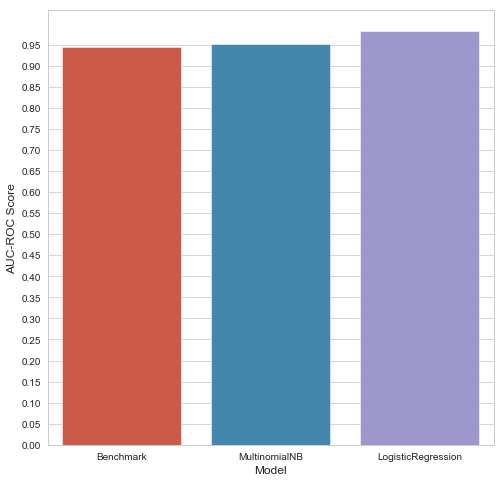

In [32]:
sns.barplot(x = "Model_Name", y = "AUC-ROC", data = results)
plt.xlabel("Model")
plt.ylabel("AUC-ROC Score")
plt.yticks(np.arange(0, 1, 0.05))
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig("./images/modelComparison.png")

_Our Logistic Regression Model has the best AUC-ROC and Kaggle score. Lets tune this model further to see if we can achieve greater performance_

##### Hyperparameter Optimization

In [33]:
# Took a lot of time!
# Lets find the most optimal hyperparameters for our Logistic model using Grid Search.

# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.model_selection import GridSearchCV

# model = OneVsRestClassifier(LogisticRegression())
# params = {'estimator__solver': ['liblinear', 'sag'], 'estimator__C' : [0.1, 0.5, 1.0]} 

# grid = GridSearchCV(model, params, cv = 3, scoring = 'roc_auc')
# grid = grid.fit(trainFeatures, train.iloc[:, 2:8])
    
# submissionModel = grid.best_estimator_

_The best estimator had C = 1 and solver = 'sag'_

Cross validation mean for className toxic is 0.9744967995408143
Cross validation mean for className severe_toxic is 0.9877662818146332
Cross validation mean for className obscene is 0.9898847398021652
Cross validation mean for className threat is 0.9838486138027648
Cross validation mean for className insult is 0.980099848229765
Cross validation mean for className identity_hate is 0.9821618527713564
Average CV AUC-ROC score of our Final Logistic Regression model is 0.9830430226602497


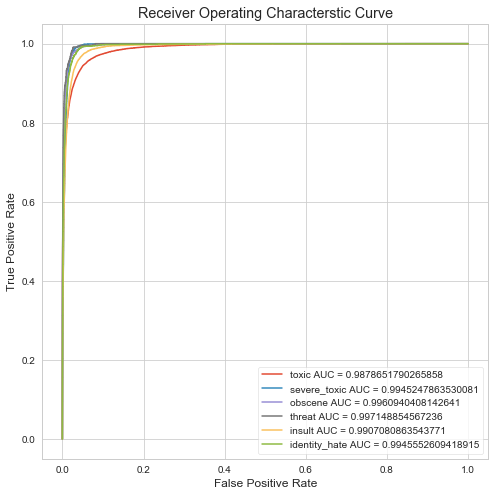

In [36]:
from sklearn import metrics
import scikitplot as skplt

scores = []
submissionFinal = pd.DataFrame.from_dict({'id': holdout['id']})
unseenRandom = pd.DataFrame.from_dict({'text': unseenRandomTextsArray})
for className in classNames:
    model = LogisticRegression(C = 1, solver = 'sag', random_state = 0)
    cv_scores = cross_val_score(model, trainFeatures, train[className], cv = 3, scoring = "roc_auc")
    mean_cv_score = np.mean(cv_scores)
    print("Cross validation mean for className {} is {}".format(className, mean_cv_score))
    scores.append(mean_cv_score)
    
    model.fit(trainFeatures, train[className])
    y_pred_proba = model.predict_proba(holdoutFeatures)[:, 1]
    submissionFinal[className] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(train[className],  model.predict_proba(trainFeatures)[:, 1])
    auc = metrics.roc_auc_score(train[className], model.predict_proba(trainFeatures)[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.plot(fpr, tpr, label = className + " AUC = " + str(auc))
    plt.legend(loc = 4)
    plt.title("Receiver Operating Characterstic Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    unseenRandom[className] = model.predict_proba(unseenRandomTextsFeatures)[:, 1]

print('Average CV AUC-ROC score of our Final Logistic Regression model is {}'.format(np.mean(scores)))

submissionFinal.to_csv('submissionFinal.csv', index = False)
plt.savefig("./images/auc.png")

In [35]:
display(unseenRandom)

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Which music is this?,0.033386,0.002561,0.006031,0.001201,0.008485,0.003998
1,This guy is spot on with his indian accent. Ha...,0.049675,0.003615,0.012038,0.001039,0.021888,0.025015
2,Canadians are so nice.,0.048635,0.002779,0.016915,0.002801,0.037965,0.020266
3,"Lmfao seemed so hard to hold it together, amaz...",0.015870,0.002778,0.007697,0.000787,0.010207,0.003975
4,I know this was hilarious and all but did anyo...,0.047792,0.002473,0.011945,0.001601,0.006755,0.002538
5,Fuck you motherfucker,0.999994,0.751648,0.999992,0.021283,0.940388,0.031014
6,shut up you faggot. go back to your shit country,0.999977,0.375695,0.998319,0.031090,0.974093,0.679593
7,why are all people here gay?,0.952851,0.055850,0.044315,0.001889,0.400917,0.856617
